# Food Delivery Time Analysis

Primary audience: Operations & Logistics team

Questions answered:
1. What are the key factors that influence delivery time?
2. How do delivery driver characteristics affect efficiency?
3. How do environmental and situational factors contribute to delays?
4. How accurately can delivery time be predicted based on available features?

Tools:Python (Pandas, NumPy, Matplotlib)

This notebook covers data cleaning, feature engineering, exploratory analysis, and preparation for Tableau dashboards.

In [64]:
# Import and Settings
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import seaborn as sns

plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.grid'] = True



# 1. Load Data & Initial Overview


In [22]:
df = pd.read_csv("train.csv")
df.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45593 non-null  object 
 1   Delivery_person_ID           45593 non-null  object 
 2   Delivery_person_Age          45593 non-null  object 
 3   Delivery_person_Ratings      45593 non-null  object 
 4   Restaurant_latitude          45593 non-null  float64
 5   Restaurant_longitude         45593 non-null  float64
 6   Delivery_location_latitude   45593 non-null  float64
 7   Delivery_location_longitude  45593 non-null  float64
 8   Order_Date                   45593 non-null  object 
 9   Time_Orderd                  45593 non-null  object 
 10  Time_Order_picked            45593 non-null  object 
 11  Weatherconditions            45593 non-null  object 
 12  Road_traffic_density         45593 non-null  object 
 13  Vehicle_conditio

# 2. Data Cleaning & Type Conversion

In this section, I:
- Standardize column names
- Clean string columns
- Fix data types for age, ratings, times, and target variable

In [71]:
# Making all column names lowercase
df.columns = df.columns.str.lower()

# Cleaning string columns
str_cols = df.select_dtypes(include = "object").columns
df[str_cols] = df[str_cols].apply(lambda s: s.str.strip())

# Convert Numeric Fields
df['delivery_person_age']= pd.to_numeric(df['delivery_person_age'], errors='coerce')
df['delivery_person_ratings'] = pd.to_numeric(df['delivery_person_ratings'], errors='coerce')
df['multiple_deliveries'] = pd.to_numeric(df['multiple_deliveries'], errors='coerce')

# Cleaning and Converting datetime fields
df['time_taken(min)'] = (df['time_taken(min)'].str.extract(r'(\d+)')[0]).astype('float64')
df['order_date'] = pd.to_datetime(df['order_date'], format='%d-%m-%Y')
df['time_orderd'] = df['time_orderd'].str.strip()     # removes trailing space
df['time_orderd'] = df['time_orderd'].replace('NaN', np.nan)
df['time_orderd']= pd.to_datetime(df['time_orderd'], format='%H:%M:%S').dt.time
df['time_order_picked'] = df['time_order_picked'].str.strip()     # removes trailing space
df['time_order_picked'] = df['time_order_picked'].replace('NaN', np.nan)
df['time_order_picked']= pd.to_datetime(df['time_order_picked'], format='%H:%M:%S').dt.time

# Cleaning the weather conditions field
df['weatherconditions'] = df['weatherconditions'].str.lower().str.replace('conditions ', '', regex=False)

## 3. Missing Data Handling

Here I:
- Identify missing and “fake missing” values
- Decide when to drop rows vs impute
- Create a cleaned dataset ready for feature engineering
- Handle explicit and “fake” missing values

In [25]:
# Standardizing missing and null values
fake_missing_patterns = ['NaN', 'nan', 'NaN ', 'NULL', 'Null', 'null', 'None', 'none', '--', ' ', '']
df = df.replace(fake_missing_patterns, np.nan)

#Key column, thus missing and null value rows need to be dropped
df = df.dropna(subset=['time_orderd'])

# Impute Numeric Fields
df['delivery_person_age'] = df['delivery_person_age'].fillna(df['delivery_person_age'].median()) # skewed distribution
df['delivery_person_ratings'] = df['delivery_person_ratings'].fillna(df['delivery_person_ratings'].mean())
df['multiple_deliveries'] = df['multiple_deliveries'].fillna(0)

# Impute Categorical Fields
df['road_traffic_density'] = df['road_traffic_density'].fillna('Unknown')
df['festival'] = df['festival'].fillna('Unknown')
df['city'] = df['city'].fillna('Unknown')

## 4. Feature Engineering

In this section I create:
- Distance between restaurant and customer
- Order and pickup timestamps
- Pickup delay in minutes
- Time-based features (hour of day, day of week, weekend, rush hour)

In [26]:
# Fix the problem of negative sign preceding the latitude and longitude values
df.loc[df['restaurant_longitude'] < 0, 'restaurant_longitude'] *= -1
df.loc[df['restaurant_latitude'] < 0, 'restaurant_latitude'] *= -1

# Calculating the distance between restaurant and the customer
def calc_distance(row) :
    start = (row['restaurant_latitude'], row['restaurant_longitude'])
    end = (row['delivery_location_latitude'], row['delivery_location_longitude'])
    return geodesic(start, end).km

df['distance_km'] = df.apply(calc_distance, axis=1)

# Build full DateTimes
df['order_datetime'] = pd.to_datetime(
    df['order_date'].astype(str) + ' ' + df['time_orderd'].astype(str),
    errors='coerce')
df['pickup_datetime'] = pd.to_datetime(
    df['order_date'].astype(str) + ' ' + df['time_order_picked'].astype(str),
    errors='coerce')

# Fix overnight pickups (pickup after midnight)
mask_overnight = df['pickup_datetime'] < df['order_datetime']
# Add 1 day to those pickup DateTimes
df.loc[mask_overnight, 'pickup_datetime'] = df.loc[mask_overnight, 'pickup_datetime'] + pd.Timedelta(days=1)

#Calcuate Pickup delay
df['pickup_delay_min'] = (
    df['pickup_datetime'] - df['order_datetime']
).dt.total_seconds() / 60

# Time based features
df['order_hour']=df['order_datetime'].dt.hour
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['order_dayofweek'] = df['order_datetime'].dt.dayofweek
df['is_weekend']=df['order_dayofweek'].isin([5,6]).astype('int')
df['is_rush_hour'] = df['order_hour'].between(7, 10) | df['order_hour'].between(17, 21)
df['is_rush_hour'] = df['is_rush_hour'].astype(int)

# Encode Traffic
traffic_order = {'Low': 1, 'Medium': 2,'High': 3,'Jam': 4,'Unknown': 0}
df['traffic_code'] = df['road_traffic_density'].map(traffic_order)

In [72]:
df.head()

,id,delivery_person_id,delivery_person_age,delivery_person_ratings,restaurant_latitude,restaurant_longitude,delivery_location_latitude,delivery_location_longitude,order_date,time_orderd,...,distance_km,order_datetime,pickup_datetime,pickup_delay_min,order_hour,pickup_hour,order_dayofweek,is_weekend,is_rush_hour,traffic_code
0,0x4607,INDORES13DEL02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30:00,...,3.020737,2022-03-19 11:30:00,2022-03-19 11:45:00,15.0,11,11,5,1,0,3
1,0xb379,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,19:45:00,...,20.143737,2022-03-25 19:45:00,2022-03-25 19:50:00,5.0,19,19,4,0,1,4
2,0x5d6d,BANGRES19DEL01,23.0,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,08:30:00,...,1.549693,2022-03-19 08:30:00,2022-03-19 08:45:00,15.0,8,8,5,1,1,1
3,0x7a6a,COIMBRES13DEL02,38.0,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,18:00:00,...,7.774497,2022-04-05 18:00:00,2022-04-05 18:10:00,10.0,18,18,1,0,1,2
4,0x70a2,CHENRES12DEL01,32.0,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,13:30:00,...,6.197898,2022-03-26 13:30:00,2022-03-26 13:45:00,15.0,13,13,5,1,0,3


## 5. Export Cleaned Dataset

This dataset is now ready for analysis and visualization.

In [28]:
df.to_csv("food_delivery_cleaned.csv", index=False)

## 6. Exploratory Analysis & Mini Dashboard

In this section, I explore delivery performance and key drivers using:
- Overall KPIs
- Distributions of delivery time
- Relationships with distance, driver characteristics, and environmental factors

This analysis is designed for the Operations & Logistics team to understand what drives delivery time and where delays occur.

In [47]:
print("=== OVERALL DELIVERY KPIs ===")

# Total deliveries
print(f"Total deliveries : {len(df):,}")

# Mean and median delivery times
print(f"Average Delivery Time (mins):    {df['time_taken(min)'].mean():.1f}")
print(f"Average Delivery Time (mins):    {df['time_taken(min)'].median():.1f}")

# Average distance of delivery
print(f"Average Delivery Distance (kms): {df['distance_km'].mean():.2f}")

# Average pickup delay
print(f"Average Pickup Delay (mins):     {df['pickup_delay_min'].mean():.2f} ")

# Average driver rating
print(f"Average Driver Rating:           {df['delivery_person_ratings'].mean():.2f}")

=== OVERALL DELIVERY KPIs ===
Total deliveries : 43,862
Average Delivery Time (mins):    26.3
Average Delivery Time (mins):    26.0
Average Delivery Distance (kms): 9.72
Average Pickup Delay (mins):     9.99 
Average Driver Rating:           4.64


### 6.1 Delivery Time Distribution

This chart shows how long deliveries typically take. It helps identify whether delivery performance is consistent, skewed, or affected by long-tail delays.

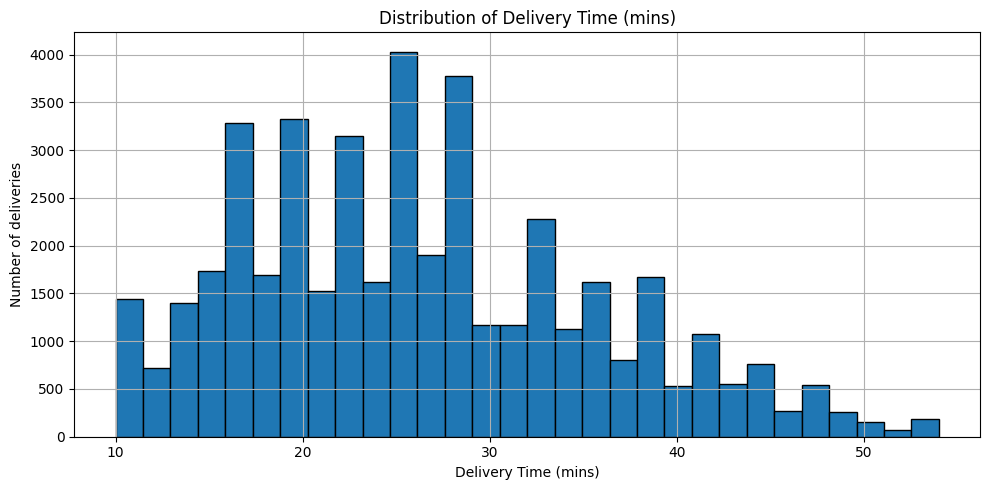

In [52]:
plt.figure(figsize = (10, 5), )
plt.hist(df['time_taken(min)'], bins = 30, edgecolor = 'black')
plt.title('Distribution of Delivery Time (mins)')
plt.xlabel('Delivery Time (mins)')
plt.ylabel('Number of deliveries')
plt.tight_layout()
plt.show()

**Observations**

- The distribution of delivery time is **right-skewed** (positively skewed). Most deliveries are completed in roughly **18–30 minutes**, with fewer deliveries taking longer.
- There is a **long right tail** up to around **50–55 minutes**, which represents a smaller set of delayed orders. These are likely driven by factors such as traffic, weather, restaurant backlog, or driver availability.
- There are **no obvious secondary peaks** or sharp spikes at a specific high value, which suggests there is **no single structural bottleneck** (e.g., a process that consistently causes extreme delays).
- Overall, delivery performance appears **reasonably consistent**, with most customers receiving their orders in a predictable time window, while a minority experience longer waits due to situational factors.

### 6.2 Delivery Time vs Distance

This scatter plot shows the relationship between how far a delivery needs to travel and how long it takes to complete the order. It helps identify whether distance is a major driver of delivery time or whether other operational factors (e.g., traffic, restaurant preparation, driver availability) contribute more heavily to delays.

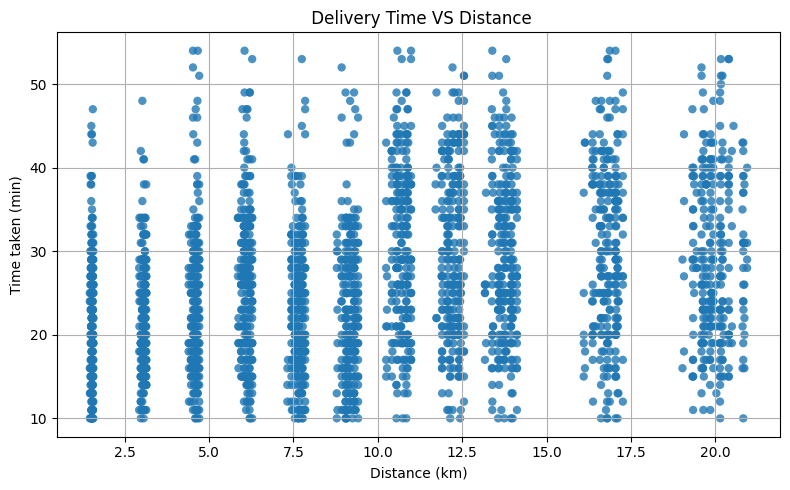

In [62]:
# Take a sample to avoid overplotting
sample = df.sample(n=3000, random_state=42) if len(df) > 3000 else df

# Scatter Plot
plt.figure(figsize = (8, 5))
plt.scatter(sample['distance_km'], sample['time_taken(min)'], alpha = 0.8, edgecolor = 'none')
plt.title(' Delivery Time VS Distance')
plt.xlabel('Distance (km)')
plt.ylabel('Time taken (min)')
plt.tight_layout()
plt.show()

**Observations**

- There is a clear **positive relationship** between delivery distance and delivery time. As distance increases, delivery time generally increases as well — which aligns with operational expectations.
- However, the points are **widely scattered**, showing that deliveries of the *same distance* can have very different completion times.
  This indicates that distance alone does **not fully explain** delivery performance.
- The variation becomes even more pronounced at mid-range distances (8–15 km), suggesting that:
  - traffic density
  - pickup delays
  - restaurant preparation time
  - driver availability
  - weather conditions
  all contribute significantly to total delivery time.
- There is **no sharp linear pattern**, meaning travel time is only one component of total delivery duration. Pickup delays and operational bottlenecks likely dominate earlier in the process.
- Overall, distance is an **important but incomplete predictor** of delivery time. This helps justify deeper analysis into environmental (traffic, weather) and driver-related factors.

### 6.3 Delivery Time vs Traffic Density
This chart compares delivery times across different levels of traffic. It helps determine how strongly traffic conditions impact overall delivery speed and whether heavy traffic leads to longer or more variable delivery durations.

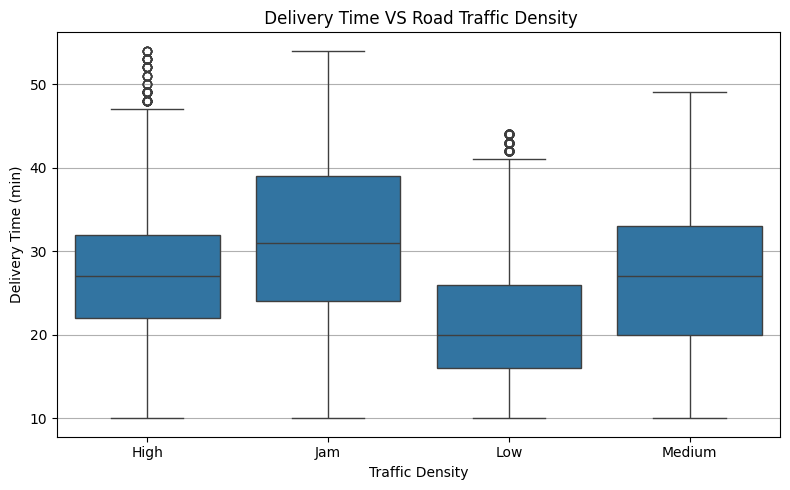

In [66]:
# Box Plot
plt.figure(figsize = (8, 5))
sns.boxplot(x = 'road_traffic_density', y = 'time_taken(min)', data = df)
plt.title(' Delivery Time VS Road Traffic Density')
plt.xlabel('Traffic Density')
plt.ylabel('Delivery Time (min)')
plt.tight_layout()
plt.show()


**Observations**

- There is a clear and consistent increase in delivery time as traffic density worsens.
  **Jam** conditions produce the longest delivery times, followed by **High**, **Medium**, and **Low** traffic.
- The **median delivery time** rises noticeably from Low → Medium → High → Jam, showing a strong relationship between congestion and delay.
- The **spread** (IQR) also becomes larger under High and Jam traffic, meaning deliveries become more **unpredictable** as traffic worsens.
- Jam conditions contain the highest number of **outliers**, indicating that extreme delays are most likely during heavy congestion.
- Overall, traffic density is revealed as a **major driver of delivery performance**, both in terms of average time and variability.
  This insight is valuable for:
  - adjusting ETAs
  - allocating drivers
  - optimizing routes
  - planning for peak-hour congestion

### 6.4 Delivery Time by Weather Conditions

This chart compares delivery times under different weather conditions. It helps determine whether adverse weather contributes to slower or more variable delivery performance.m

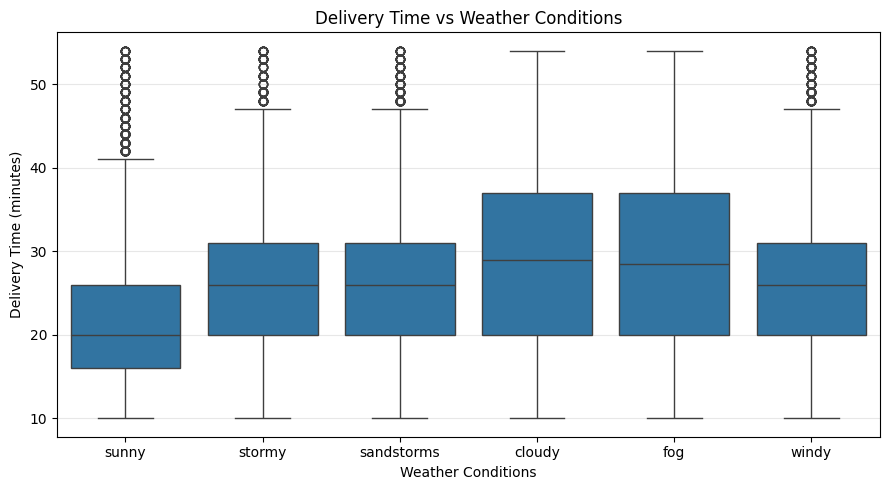

In [73]:
# Box Plot
plt.figure(figsize=(9,5))
sns.boxplot(data=df, x='weatherconditions', y='time_taken(min)')
plt.title("Delivery Time vs Weather Conditions")
plt.xlabel("Weather Conditions")
plt.ylabel("Delivery Time (minutes)")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

**Observations**

- Delivery times tend to increase under **adverse weather conditions**. Stormy, foggy, and cloudy weather all show higher median delivery times compared to sunny weather.
- Sunny conditions result in the **fastest and most consistent** delivery times, with a tighter spread and fewer extreme delays.
- Conditions like **cloudy**, **fog**, and **sandstorms** show a noticeably wider spread of delivery times, indicating greater operational variability and unpredictability during poor weather.
- Severe weather categories also contain a larger number of **outliers**, suggesting that extreme delays are far more common when visibility is low or driving conditions are difficult.
- Overall, weather plays a **meaningful role** in delivery time. Although the effect is less dramatic than traffic density, it still contributes to longer and more inconsistent delivery durations and should be considered in ETA modeling and resource planning.

### 6.5 Pickup Delay vs Delivery Time

This chart examines how delays at the restaurant (pickup delay) impact the overall delivery time. Pickup delay often reflects preparation time, restaurant efficiency, or waiting for drivers to arrive.m

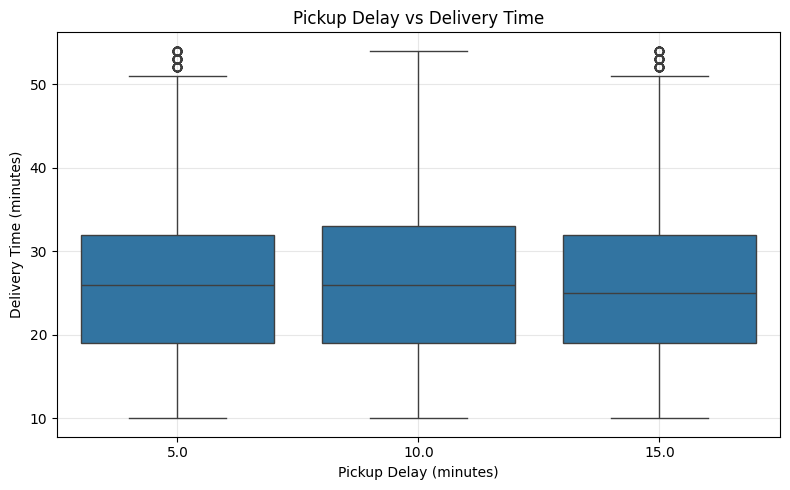

In [77]:
# Box Plot
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='pickup_delay_min', y='time_taken(min)')
plt.title("Pickup Delay vs Delivery Time")
plt.xlabel("Pickup Delay (minutes)")
plt.ylabel("Delivery Time (minutes)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**Observations**

- Pickup delays in the dataset appear in only a few discrete values (primarily around 5, 10, and 15 minutes). This suggests that pickup times are recorded or rounded in coarse intervals rather than continuously.
- Even with this coarse grouping, the pattern is clear: **longer pickup delays are associated with longer overall delivery times**.
- Deliveries with a pickup delay near **5 minutes** generally have lower and less variable delivery times.
- When pickup delay increases to around **10 minutes**, delivery times spread upward, showing both higher averages and greater inconsistency.
- At **15 minutes**, delivery duration increases further, with more occurrences of high delivery times (40–55 minutes).
- These results highlight pickup delay as a **major operational driver** of total delivery duration. Improvements in restaurant preparation efficiency or driver coordination could directly reduce total delivery time.

### 6.6 Delivery Time vs Driver Ratings

This chart explores whether delivery drivers with higher customer ratings tend to complete deliveries faster and more consistently. Driver ratings may reflect skill, experience, or service quality, all of which can influence delivery efficiency.

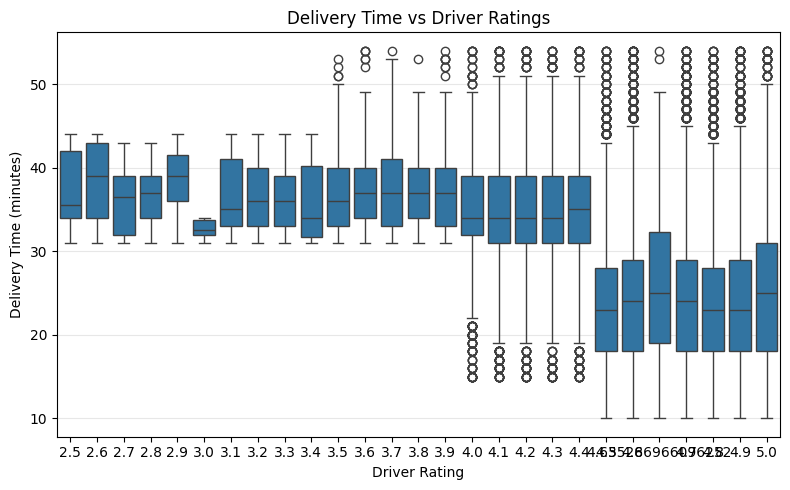

In [78]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='delivery_person_ratings', y='time_taken(min)')
plt.title("Delivery Time vs Driver Ratings")
plt.xlabel("Driver Rating")
plt.ylabel("Delivery Time (minutes)")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

**Observations**

- There is a general trend showing that **higher-rated drivers tend to have lower delivery times** and more consistent performance.
- Drivers with ratings near **2.5–3.5** display the **highest median delivery times** and the **widest variation**, indicating inconsistent efficiency.
- As ratings increase beyond **4.0**, both the median and spread of delivery times tend to decrease.
  This suggests that more experienced or better-performing drivers complete deliveries more efficiently.
- The number of outliers also decreases as ratings increase, meaning fewer extreme delays are associated with high-rated drivers.
- While the effect is not as strong as traffic or pickup delay, driver ratings still reflect a **measurable impact on operational efficiency**, supporting the idea that training and performance management play a key role in delivery outcomes.

### 6.7 Correlation Heatmap

This heatmap highlights the strength of relationships between numerical features

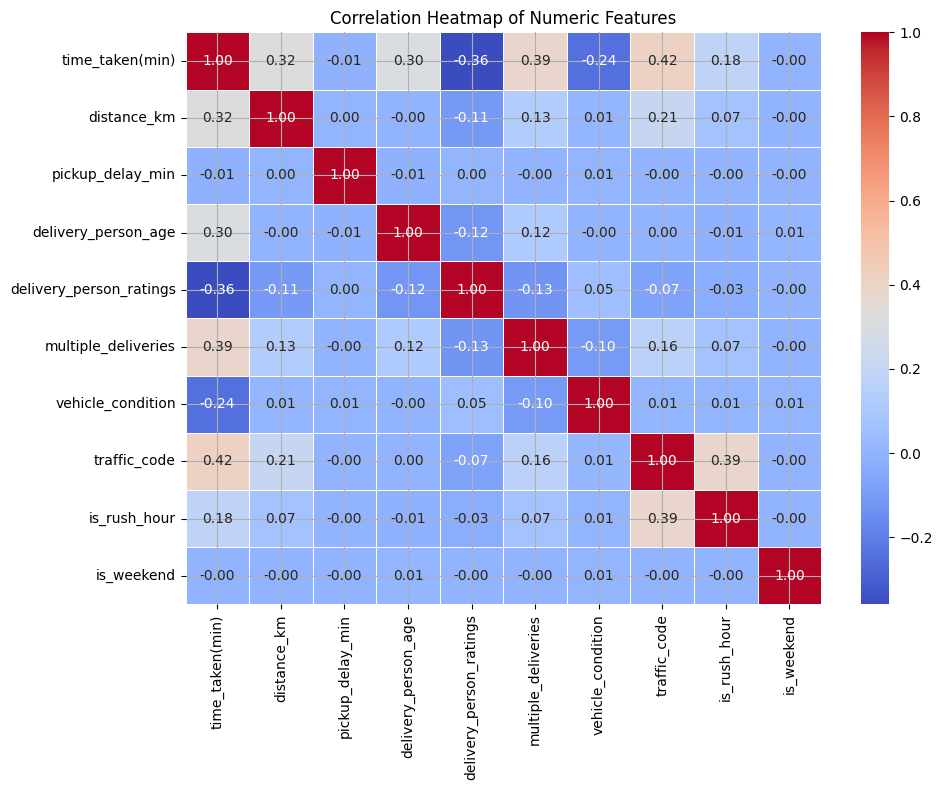

In [83]:
corr_features = [
    'time_taken(min)',
    'distance_km',
    'pickup_delay_min',
    'delivery_person_age',
    'delivery_person_ratings',
    'multiple_deliveries',
    'vehicle_condition',
    'traffic_code',
    'is_rush_hour',
    'is_weekend'
]

# Compute correlation matrix
corr_df = df[corr_features]
corr_matrix = corr_df.corr()


# Heat Map
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
plt.show()

**Observations**

- **Traffic density** (encoded as `traffic_code`) shows the strongest positive correlation with delivery time (0.42). This confirms that congestion is one of the most influential factors in delaying deliveries.
- **Multiple deliveries** also correlate positively with delivery time (0.39). When drivers handle more than one order, delivery times naturally increase due to additional stops or route adjustments.
- **Delivery distance** shows a moderate positive correlation (0.32), consistent with earlier scatter plot findings. Distance matters, but it is not the primary driver.
- **Driver ratings** show a moderate **negative** correlation (-0.36), suggesting that higher-rated drivers tend to deliver faster and more consistently.
- **Vehicle condition** is weakly negatively correlated (-0.24), implying that poor vehicle condition may contribute slightly to delays.
- **Rush hour** shows a mild positive correlation (0.18), indicating that peak times add some delay but not as strongly as traffic or multiple deliveries.
- **Pickup delay** surprisingly shows almost no correlation in this summary. This is likely due to the pickup delay values being recorded in only a few discrete bands (5, 10, 15 minutes), which weakens the correlation measure even though earlier visual analysis showed a meaningful trend.
- **Weekend** has virtually no impact (close to zero), indicating that delivery time is similar on weekdays and weekends.

**Conclusion:**
Delivery performance is influenced by a combination of **traffic**, **multiple deliveries**, **driver quality**, and **distance**, with traffic being the most impactful. No single variable completely explains delivery time, which supports the value of predictive modeling.